In [1]:
import sys,os,pickle,copy
sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
import numpy as np
import numpy
import pandas as pd
import scipy
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
from importlib import reload
import seaborn as sns

import preprocess as prep

from sklearn.decomposition import NMF

import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
import matplotlib.pyplot as plt
%matplotlib inline

import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import pynapple as nap

In [2]:
sess_name="e15_13f1_220117"#'e13_26m1_210913'#
data_dir_full = "/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117"#'/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913' #
py_data_dir = os.path.join(data_dir_full,"py_data")
fr_ = pickle.load(open(os.path.join(py_data_dir,'fr.p'),'rb'))
pos_bins = fr_['pos_bins']['lin']
bin_to_lin=numpy.concatenate([pos_bins[:-1,None],pos_bins[1:,None]],axis=1).mean(axis=1)

fr_df=  fr_['df']
fr_pyr = fr_['df']['pyr']
fr_int = fr_['df']['int']
fr_map_trial = pickle.load(open(os.path.join(py_data_dir,'fr_map.p'),'rb'))['fr_map_trial']
fr_map_avg=pickle.load(open(os.path.join(py_data_dir,'fr_map.p'),'rb'))['fr_map']
cell_cols = fr_['cell_cols']
cell_cols_pyr=np.array(cell_cols['pyr'],dtype=object)
cell_cols_int =np.array(cell_cols['int'],dtype=object)


In [3]:
data_dir_full = data_dir_full
to_return=prep.load_stuff(data_dir_full)

cell_metrics=to_return['cell_metrics']
behavior=to_return['behavior']
ripple_events=to_return['ripple_events']
mergepoints=to_return['mergepoints']
cell_type_mask=to_return['cell_type_mask']
pyr_uid=to_return['pyr_uid']

trial_ind_d = {ch:np.nonzero(behavior.trials.visitedArm==ch)[0] for ch in [0,1]}
dt = np.diff(behavior.timestamps).mean()

In [4]:
import glob
mono_res=glob.glob(os.path.join(data_dir_full,'*mono_res*'))[0]
mono_res = dpn.loadmat_full(mono_res,'mono_res')

In [5]:
fn = os.path.join(data_dir_full,'py_data','synapses_all_epoch.p')
synapses= pickle.load(open(fn,'rb'))

In [6]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering


# nmf

In [337]:
reload(na)

<module 'nmf_analysis' from '/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py'>

In [7]:
# nmf directly
nbins = 10
# convert to rate:
fr_pyr.loc[:,cell_cols_pyr] = fr_pyr.loc[:,cell_cols_pyr]/dt
fr_filtered = copy.copy(fr_pyr.query("(speed>=1.)"))
fr_filtered['lin_binned'] = pd.cut(fr_filtered['lin'],nbins,retbins=False,labels=False)
fr_mean_trial_type = fr_filtered.groupby(['visitedArm','trial','lin_binned']).mean().loc[:,cell_cols_pyr]

trial_type = 0
fr_to_be_nmfed_one_trialtype = fr_mean_trial_type.loc[trial_type]

n_compo = 4
W_df, W_sorted,W_inds, factor_assignment, H_sorted, X_sorted, X_recon_sorted,X_normed_restacked_df = na.nmf_sort_with_position(fr_to_be_nmfed_one_trialtype,n_compo, model=None,do_normalize=True)
W_df_original = copy.copy(W_df)
W_df_peaks_only=na.get_peaks_in_W(W_df,n_compo)

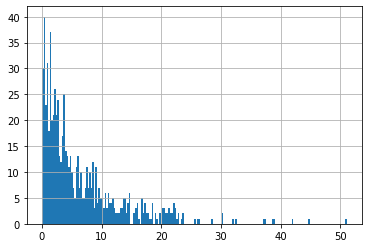

In [293]:
# get peaks first then nmf
reload(na)

fr_peak_only=na.get_peaks_in_W(fr_to_be_nmfed_one_trialtype.unstack().T,None)
(fr_peak_only.max(axis=1)/0.033).hist(bins=200)

# filter out weak peaks
max_fr_thresh = 1
fr_peak_only = fr_peak_only.loc[fr_peak_only.max(axis=1)/0.033 > max_fr_thresh]

pyr_left = fr_peak_only.index.get_level_values(0).unique()
# get the original index for the pyr left in nmf
non_na_original_ind = np.nonzero(np.equal.outer(pyr_left,cell_cols_pyr))[1]

fr_peak_only_unstacked=fr_peak_only.unstack()
X_normed_restacked_df = (fr_peak_only_unstacked / fr_peak_only_unstacked.max(axis=1).values[:,None]).stack()
X_normed_restacked = X_normed_restacked_df.values

neuron_position_index = fr_peak_normed.index

neuron_position_index_integer = pd.MultiIndex.from_arrays([pd.factorize(neuron_position_index.get_level_values(0))[0],neuron_position_index.get_level_values(1)])

X_normed_restacked_df.index=neuron_position_index_integer # for compatibility with the plotting function



n_compo = 3
W, W_sorted,W_inds, factor_assignment, H_sorted, X_sorted, X_recon_sorted = na.nmf_and_sort(X_normed_restacked, n_compo, model=None)

# W_df = pd.DataFrame(W,neuron_position_index)
W_df = pd.DataFrame(W,neuron_position_index_integer)
W_df_peaks_only=W_df

(<Figure size 666x2397.6 with 4 Axes>,
 {'W': <AxesSubplot:label='W', xlabel='component', ylabel='neuron'>,
  'H': <AxesSubplot:label='H', ylabel='component'>})

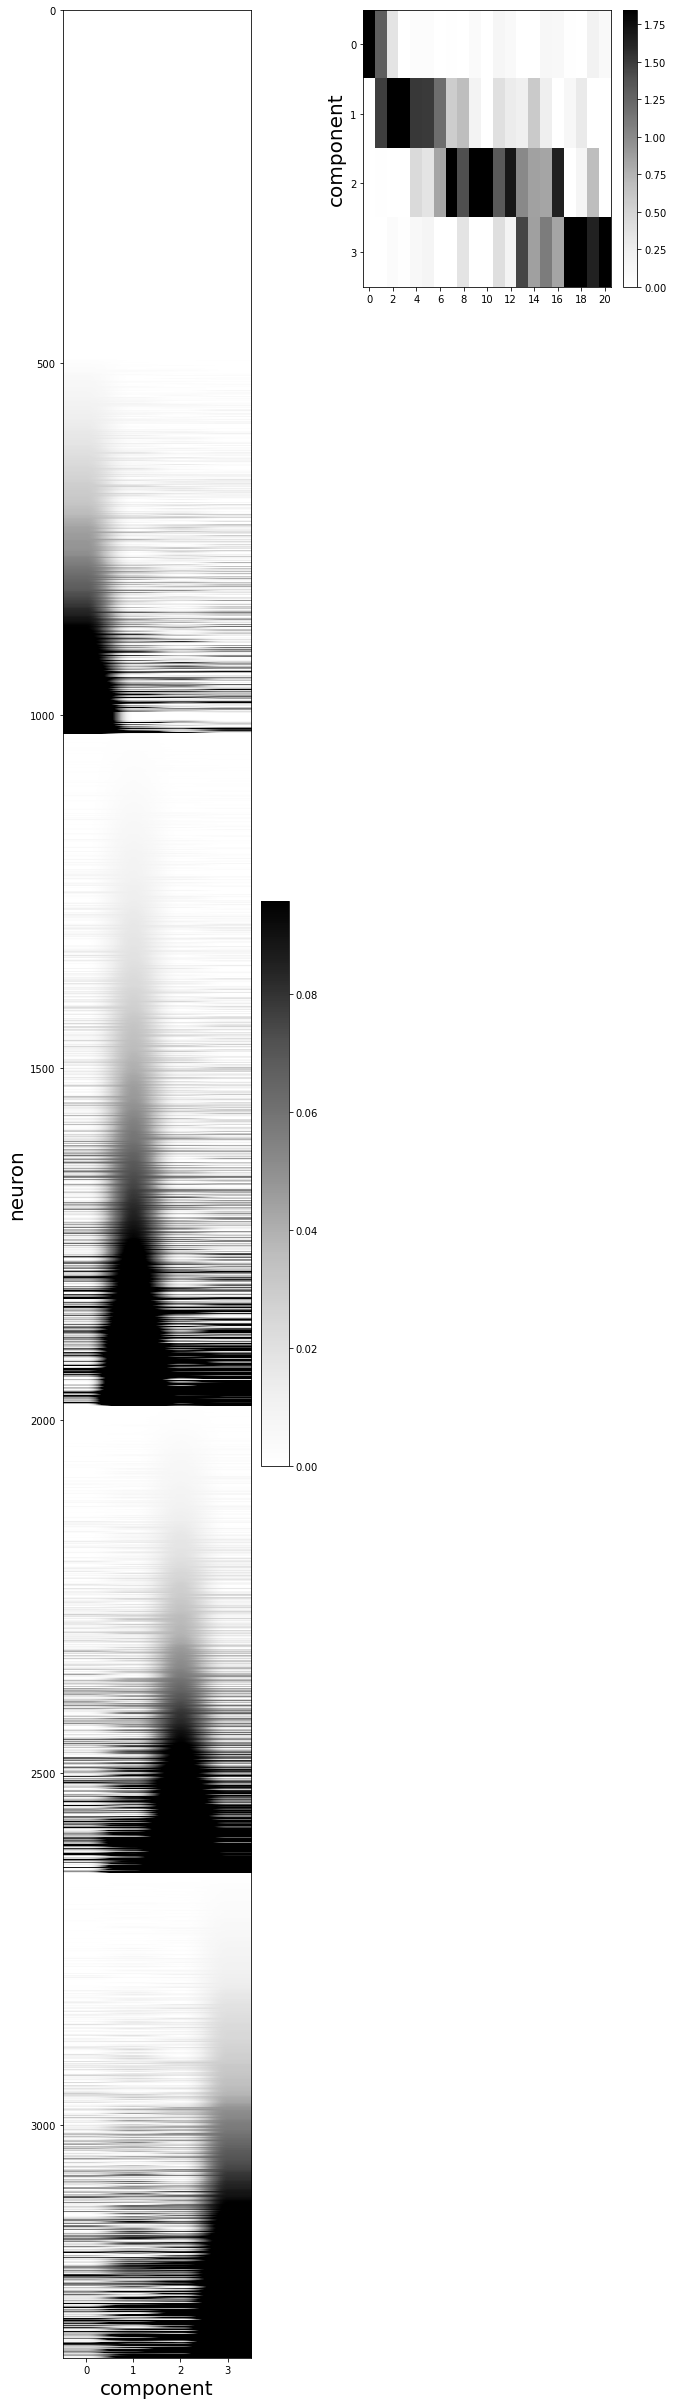

In [348]:
nmfp.plot_wh(W_sorted, H_sorted,factor_neuron_ratio=100,spacing=2)

(<Figure size 666x799.2 with 4 Axes>,
 {'W': <AxesSubplot:label='W', xlabel='component', ylabel='neuron'>,
  'H': <AxesSubplot:label='H', ylabel='component'>})

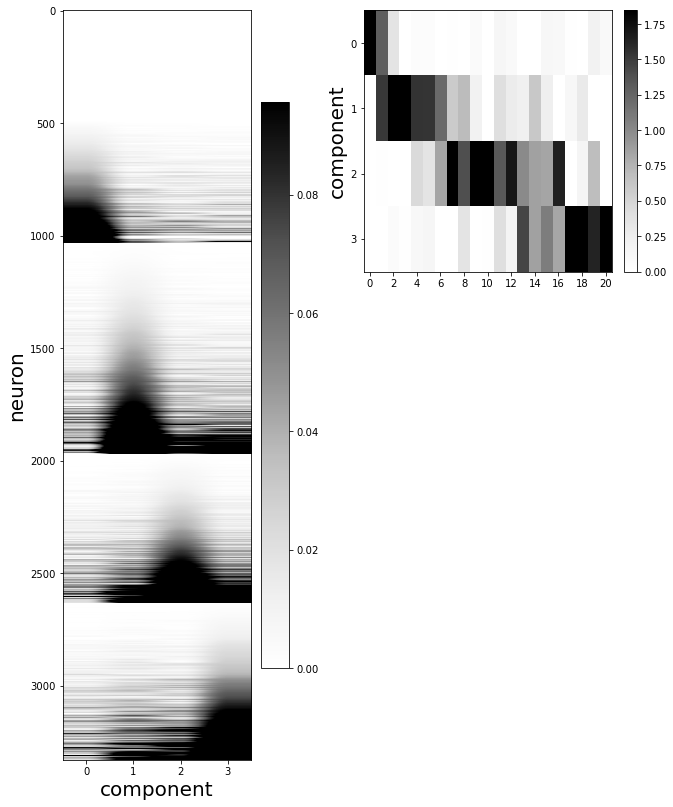

In [8]:
# old nmf on all positions
nmfp.plot_wh(W_sorted, H_sorted,factor_neuron_ratio=300,spacing=2)

In [8]:
n_clust = 6
ct ='pyr'
trial='0'
W = W_df_peaks_only#W_d_d[ct][trial]
res=KMeans(n_clust).fit(W)
clust = res.labels_
centroid = res.cluster_centers_

In [9]:
# W_df = na.add_metrics_to_W(W, W.shape[1], pd_kwargs={})
W_df = na.add_metrics_to_W(W_df_peaks_only, n_compo, pd_kwargs={})

In [10]:
W_df['clust'] = clust
W_df['factor'] = W_df.loc[:,0:n_compo-1].idxmax(axis=1)

<AxesSubplot:>

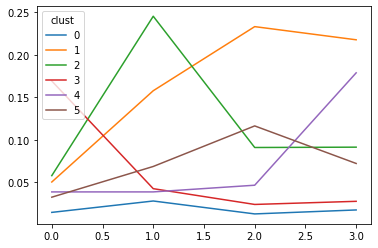

In [11]:
# n_compo = W.shape[1]
W_df.groupby('clust').mean().loc[:,0:n_compo-1].T.plot()

In [12]:
# sort_func = lambda x:na.hierarchical_sort(x,to_cut_keys=['sum'],to_cut_nbins=[4],final_sort_key=f'skew_{x.name}',ascending=False)
# sort_func = lambda x:na.hierarchical_sort(x,to_cut_keys=['sum'],to_cut_nbins=[2],final_sort_key=f'skew',ascending=False)

sort_func = lambda x:na.hierarchical_sort(x,to_cut_keys=[f'skew_{x.name}','skew'],to_cut_nbins=[4,4],final_sort_key=x.name,ascending=False)

# W_df_sorted = W_df.groupby('clust').apply(sort_func)
W_df_sorted = W_df.groupby('factor').apply(sort_func)
# W_df_sorted = sort_func(W_df)


In [14]:
W_df_sorted

0         1         2         3       sum  \
factor          lin_binned                                                     
0      unit_333 7           0.277152  0.021328  0.000500  0.000000  0.298980   
       unit_343 5           0.258444  0.022353  0.018714  0.053001  0.352512   
       unit_284 7           0.258407  0.043018  0.034497  0.052306  0.388228   
       unit_225 1           0.251258  0.000000  0.000000  0.000000  0.251258   
       unit_132 2           0.248414  0.085695  0.001108  0.005214  0.340431   
...                              ...       ...       ...       ...       ...   
3      unit_226 4           0.084526  0.020452  0.068599  0.090458  0.264034   
       unit_293 3           0.063193  0.062482  0.000000  0.065696  0.191370   
       unit_281 6           0.044519  0.055031  0.000000  0.063987  0.163537   
       unit_360 7           0.024191  0.057170  0.049518  0.060269  0.191147   
       unit_341 3           0.009578  0.013254  0.000000  0.015075  0.037907   

                             entropy      skew    skew_0        skew_1  \
factor          lin_binned                                               
0      unit_333 7           0.269329  1.136372  5.154159 -9.473813e-02   
       unit_343 5           0.843207  1.094623  5.056406 -2.912451e-01   
       unit_284 7           0.999872  1.138983  5.160726 -1.938763e-01   
       unit_225 1           0.000000  1.154701  5.196152 -1.924501e-01   
       unit_132 2           0.659825  0.809847  4.337586  2.016225e-07   
...                              ...       ...       ...           ...   
3      unit_226 4           1.279940 -0.885322  0.305644 -4.551300e+00   
       unit_293 3           1.098380 -1.148194  0.171151  1.484434e-01   
       unit_281 6           1.087852 -0.893331  0.003229  1.904271e-01   
       unit_360 7           1.336443 -0.909678 -4.613573  2.900912e-01   
       unit_341 3           1.081716 -0.789045  0.000005  2.735066e-01   

                              skew_2    skew_3  clust  factor  skew_0_binned  \
factor          lin_binned                                                     
0      unit_333 7          -0.254377 -0.259555      4       0            3.0   
       unit_343 5          -0.342307 -0.044361      4       0            3.0   
       unit_284 7          -0.300809 -0.110108      4       0            3.0   
       unit_225 1          -0.192450 -0.192450      4       0            3.0   
       unit_132 2          -0.590297 -0.507902      4       0            3.0   
...                              ...       ...    ...     ...            ...   
3      unit_226 4           0.000836  0.703532      5       3            NaN   
       unit_293 3          -5.181629  0.269258      0       3            NaN   
       unit_281 6          -4.596324  0.829344      0       3            NaN   
       unit_360 7           0.001821  0.682947      0       3            NaN   
       unit_341 3          -4.320340  0.890649      0       3            NaN   

                            skew_binned  skew_1_binned  skew_2_binned  \
factor          lin_binned                                              
0      unit_333 7                     3            NaN            NaN   
       unit_343 5                     3            NaN            NaN   
       unit_284 7                     3            NaN            NaN   
       unit_225 1                     3            NaN            NaN   
       unit_132 2                     3            NaN            NaN   
...                                 ...            ...            ...   
3      unit_226 4                     0            NaN            NaN   
       unit_293 3                     0            NaN            NaN   
       unit_281 6                     0            NaN            NaN   
       unit_360 7                     0            NaN            NaN   
       unit_341 3                     0            NaN            NaN   

                            skew_3_binne

<AxesSubplot:ylabel='factor-None-lin_binned'>

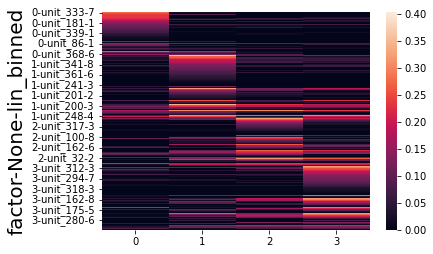

In [15]:
sns.heatmap(W_df_sorted.loc[:,0:n_compo-1])

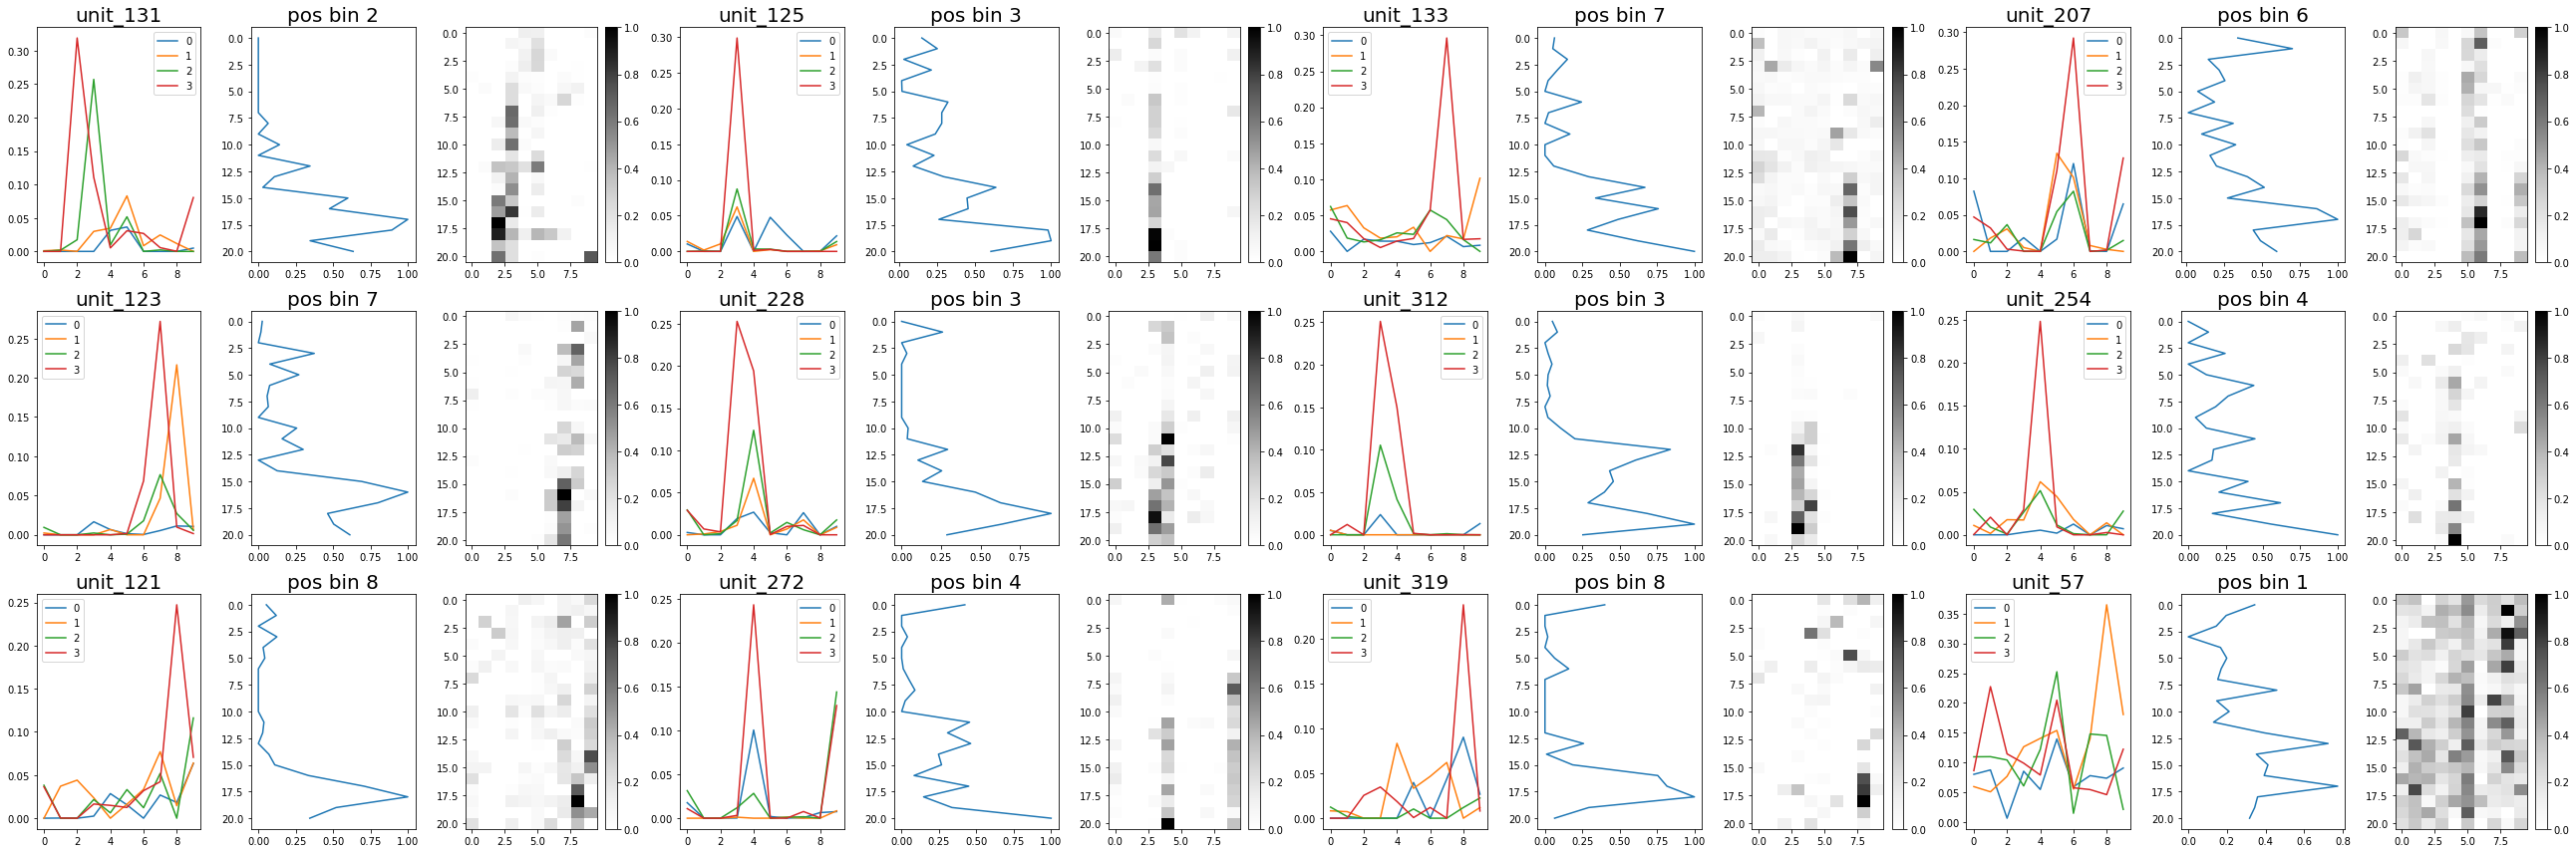

In [445]:
reload(nmfp)
clust=3
sample_inds = W_df_sorted.loc[clust].index[:12]
# sample_inds = W_df_sorted.index[:12]
fig,axs=nmfp.plot_example_W_and_ratemaps(W_df_original, sample_inds,X_normed_restacked_df,n_compo=n_compo)



# synapse

In [13]:
fr_int.loc[:,cell_cols_int] = fr_int.loc[:,cell_cols_int]/dt
fr_filtered = copy.copy(fr_int.query("(speed>=1.)"))
fr_filtered['lin_binned'] = pd.cut(fr_filtered['lin'],nbins,retbins=False,labels=False)
fr_mean_trial_type_int = fr_filtered.groupby(['visitedArm','trial','lin_binned']).mean().loc[:,cell_cols_int]

fr_to_be_nmfed_one_trialtype_int=fr_mean_trial_type_int.loc[trial_type]

<AxesSubplot:>

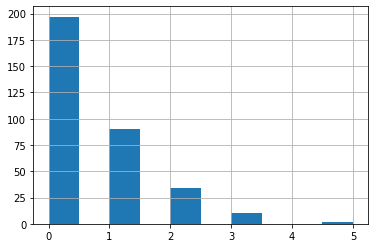

In [18]:
synapse_df=dict(
inh= pd.DataFrame(synapses['int_inh_pyr'],index=cell_cols_int,columns=cell_cols_pyr),
exc = pd.DataFrame(synapses['pyr_exc_int'].T,index=cell_cols_int,columns=cell_cols_pyr),
    )
synapse_df['inh_only'] = np.logical_and(synapse_df['inh'],np.logical_not(synapse_df['exc']))
synapse_df['inh_only'].sum(axis=0).hist()

In [19]:
ii=5
ex_uname,pos=W_df_sorted.loc[3].index[ii]
print(ex_uname,pos)
# ex_uname='unit_131'
int_mask_d={}
for key,df in synapse_df.items():
    int_mask_d[key]=df[ex_uname].astype(bool)

unit_228 3


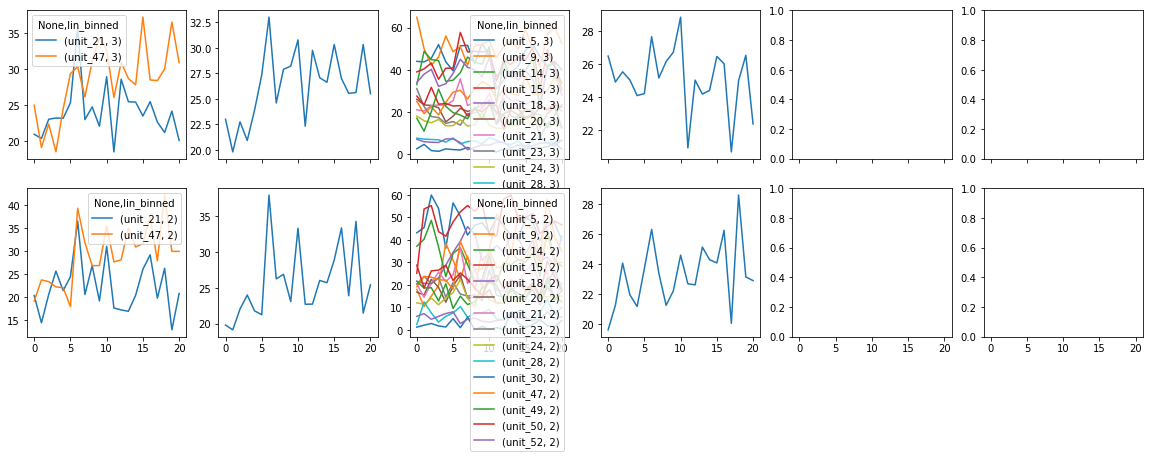

In [20]:
nsynapse_types = len(int_mask_d)
fig,axs=plt.subplots(2,2*nsynapse_types,figsize=(20,6),sharex=True,sharey=False)
counter = 0
for key,int_mask in int_mask_d.items():
    try:
        toplot=fr_to_be_nmfed_one_trialtype_int.loc[:,int_mask].unstack().loc[:,(slice(None),pos)]
        toplot=toplot.reset_index(drop=True)
        toplot.plot(ax=axs[0,counter])
        toplot.mean(axis=1).plot(ax=axs[0,1+counter])

        toplot=fr_to_be_nmfed_one_trialtype_int.loc[:,int_mask].unstack().loc[:,(slice(None),pos-1)]
        toplot=toplot.reset_index(drop=True)
        toplot.plot(ax=axs[1,counter])
        toplot.mean(axis=1).plot(ax=axs[1,counter+1])
    
    except:
        pass
    counter+=2

<AxesSubplot:>

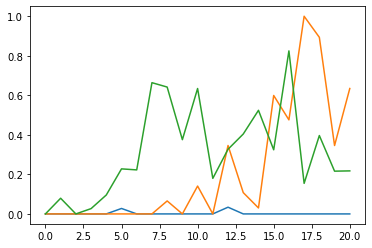

In [261]:
X_normed_restacked_df.loc[ex_uname,pos-1].reset_index(drop=True).plot()
X_normed_restacked_df.loc[ex_uname,pos].reset_index(drop=True).plot()
X_normed_restacked_df.loc[ex_uname,pos+1].reset_index(drop=True).plot()

In [ ]:
# scipy.stats.pearsonr(X_normed_restacked_df.loc[ex_uname,pos].iloc[:10],toplot.sum(axis=1).iloc[:10])
# scipy.stats.pearsonr(X_normed_restacked_df.loc[ex_uname,pos].iloc[10:],toplot.sum(axis=1).iloc[10:])
scipy.stats.pearsonr(X_normed_restacked_df.loc[ex_uname,pos],toplot.sum(axis=1))

# look at rasters at the time of pop up

In [56]:
import ruptures as rpt

In [23]:
import pynapple as nap

In [112]:
spikes = nap.TsGroup({int(cell_metrics.UID[nn]):nap.Ts(t=times,time_units='s') for nn,times in enumerate(cell_metrics.spikes.times)})


In [116]:
X_normed_restacked_df.loc[ex_uname,pos]

trial
0.0     0.000000
2.0     0.259259
4.0     0.000000
6.0     0.032864
11.0    0.000000
12.0    0.000000
13.0    0.000000
15.0    0.000000
17.0    0.000000
18.0    0.000000
20.0    0.040936
21.0    0.035569
23.0    0.291667
24.0    0.103245
26.0    0.253623
27.0    0.132576
28.0    0.466667
29.0    0.627451
30.0    0.947917
31.0    0.636364
33.0    0.287390
Name: (unit_228, 3), dtype: float64

In [494]:
ii=1
ex_uname,pos=W_df_sorted.loc[3].index[ii]
print(ex_uname,pos)
int_mask_d={}
for key,df in synapse_df.items():
    int_mask_d[key]=df[ex_uname].astype(bool)
    
xx=X_normed_restacked_df.loc[ex_uname,pos].values
algo = rpt.Dynp(model='l2').fit(xx)
change_points = algo.predict(n_bkps=1)
change_points_original_trialindex=[X_normed_restacked_df.loc[ex_uname,pos].index[c] for c in change_points[:-1]]
print(change_points)
print(change_points_original_trialindex)

unit_125 3
[15, 21]
[27.0]


In [495]:
X_normed_restacked_df.loc[ex_uname,pos].index

Float64Index([ 0.0,  2.0,  4.0,  6.0, 11.0, 12.0, 13.0, 15.0, 17.0, 18.0, 20.0,
              21.0, 23.0, 24.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 33.0],
             dtype='float64', name='trial')

In [496]:
# epoch=fr_filtered.query('(lin_binned==@pos)&(trial>=@change_points_original_trialindex[0])&(trial<=(@change_points_original_trialindex[0]+3))')['times'].agg(min='min',max='max')
epoch=fr_filtered.query('(lin_binned==@pos)&(trial==@change_points_original_trialindex[0]+1)')['times'].agg(min='min',max='max')
epoch = nap.IntervalSet(start=[epoch.loc['min']],end=[epoch.loc['max']],time_units='s')


In [497]:
get_uid = lambda s:int(s.split('_')[1])

In [498]:

synapse_key = 'inh'
# synapse_key = 'exc'
int_uids =[get_uid(s) for s in int_mask_d[synapse_key].index[int_mask_d[synapse_key]]]
ex_uid = get_uid(ex_uname)
spikes_ex=dict(
pyr = spikes[ex_uid],
int = spikes[int_uids]
)

In [500]:
spikes_ex_restricted = {k:v.restrict(epoch) for k,v in spikes_ex.items()}


In [501]:
lin_tsd=nap.Tsd(behavior['timestamps'],behavior['position']['lin'])

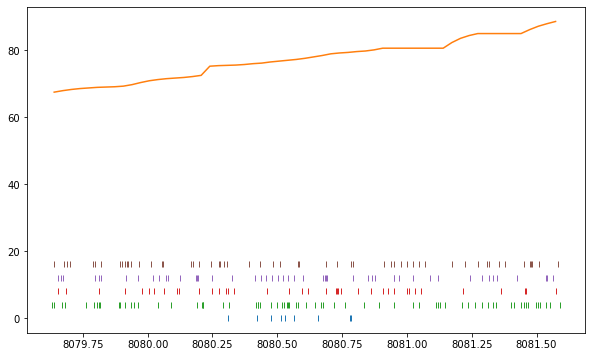

In [502]:
# plt.figure(figsize=((epoch['end']-epoch['start']).values[0]*2 , 6))
plt.figure(figsize=(10 , 6))
plt.plot(spikes_ex_restricted['pyr'].fillna(0),'|')
plt.plot(lin_tsd.restrict(epoch))
# plt.figure()
for ii,nn in enumerate(spikes_ex_restricted['int'].keys()):
    plt.plot(spikes_ex_restricted['int'][nn].fillna((ii+1)*4),'|')

In [503]:
spikes_ex_restricted

{'pyr': Time (s)
 8080.308933   NaN
 8080.423133   NaN
 8080.476133   NaN
 8080.512867   NaN
 8080.529867   NaN
 8080.566333   NaN
 8080.657033   NaN
 8080.780633   NaN
 8080.785533   NaN
 dtype: float64,
 'int':   Index    Freq. (Hz)
 -------  ------------
      18         35.58
      20         19.83
      21         25.42
      47         28.47}

In [506]:
beg_end_at_one_position_all_trials = fr_filtered.query('lin_binned==@pos').groupby(['visitedArm','trial'])['times'].agg(begin='min',end='max')
beg_end_at_one_position_all_trials_one_trialtype=beg_end_at_one_position_all_trials.loc[trial_type]


In [507]:
epochs_d=dict(
    popup = beg_end_at_one_position_all_trials_one_trialtype.iloc[change_points[0]:change_points[0]+3],
    before=beg_end_at_one_position_all_trials_one_trialtype.iloc[:change_points[0]],
    after=beg_end_at_one_position_all_trials_one_trialtype.iloc[change_points[0]+3:]
)
for k,epoch in epochs_d.items():
    epochs_d[k] = nap.IntervalSet(start=epoch['begin'],end=epoch['end'],time_units='s')

# epochs_before = beg_end_at_one_position_all_trials_one_trialtype.iloc[:change_points[0]]
# epochs_before = nap.IntervalSet(start=epochs_before['begin'],end=epochs_before['end'],time_units='s')

In [508]:
binsize=0.05
windowsize=0.2

c_l_d = {}
for k,epoch in epochs_d.items():
    c_l_d[k] = {}
    spikes_ex_restricted = {k:v.restrict(epoch) for k,v in spikes_ex.items()}

    for int_uid in int_uids:
        c,time_bins=nap.cross_correlogram(spikes_ex_restricted['pyr'].index.to_numpy(),spikes_ex_restricted['int'][int_uid].index.to_numpy(),binsize=binsize,windowsize=windowsize)
        c_l_d[k][int_uid]=c
    c_l_d[k] = pd.DataFrame(c_l_d[k],index=time_bins)
    

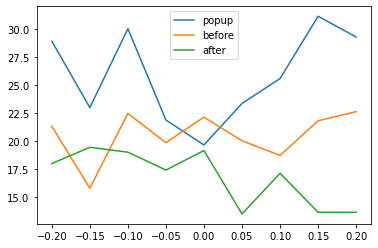

In [511]:
ii=1
for k,c_l in c_l_d.items():
    c_l.iloc[:,ii].plot(label=k)
plt.legend()

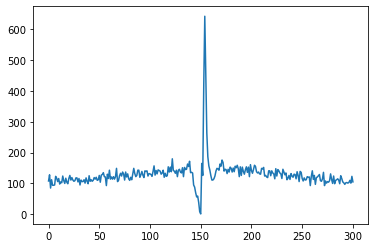

In [512]:
plt.plot(mono_res.ccgR[:,ex_uid-1,int_uids[ii]-1])

# fr flow

In [451]:
xx = X_normed_restacked_df.loc['unit_131']  

In [455]:
xx_normed = xx / xx.sum(axis=0).values[None,:]

In [460]:
xx_normed

trial,0.0,2.0,4.0,6.0,11.0,12.0,13.0,15.0,17.0,18.0,...,21.0,23.0,24.0,26.0,27.0,28.0,29.0,30.0,31.0,33.0
lin_binned,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.064452,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.055293,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.022400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.084278,0.000000,...,0.00000,0.228070,0.190026,0.043404,0.635247,0.326999,0.866098,0.400192,0.615385,0.398318
3,0.000000,0.233242,0.000000,0.063382,0.502644,0.456748,0.359728,0.832317,0.824162,0.820658,...,0.43506,0.215598,0.713017,0.752966,0.343951,0.566799,0.133902,0.177622,0.384615,0.136666
4,0.482147,0.151292,0.262598,0.316909,0.133201,0.093053,0.000000,0.000000,0.059611,0.013413,...,0.00000,0.135609,0.000000,0.000000,0.000000,0.005973,0.000000,0.055005,0.000000,0.000000
5,0.430004,0.615466,0.636295,0.598779,0.061667,0.047394,0.130996,0.149469,0.031949,0.165930,...,0.56494,0.391543,0.096957,0.203630,0.000000,0.100230,0.000000,0.175532,0.000000,0.009795
6,0.000000,0.000000,0.101107,0.000000,0.000000,0.000000,0.073630,0.018214,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.145563,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.178394,0.131558,0.415289,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046086,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.020931,0.059642,0.215954,0.020358,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.020803,0.000000,0.000000,0.000000,0.000000,0.000000


In [513]:
xx_normed.diff(axis=0).diff(axis=1)

trial,0.0,2.0,4.0,6.0,11.0,12.0,13.0,15.0,17.0,18.0,...,21.0,23.0,24.0,26.0,27.0,28.0,29.0,30.0,31.0,33.0
lin_binned,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.000000,0.000000,0.000000,-0.064452,0.119745,-0.055293,0.000000,0.000000,0.000000,...,0.000000,0.022400,-0.022400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,NaN,0.000000,0.000000,0.000000,0.000000,-0.055293,0.055293,0.000000,0.084278,-0.084278,...,-0.174051,0.205670,-0.015645,-0.146622,0.591843,-0.308248,0.539099,-0.465906,0.215192,-0.217066
3,NaN,0.233242,-0.233242,0.063382,0.439263,-0.045896,-0.097020,0.472589,-0.092433,0.080774,...,-0.174117,-0.447533,0.535464,0.186571,-1.000859,0.531096,-0.971995,0.509625,-0.008198,-0.030883
4,NaN,-0.564097,0.344548,-0.009071,-0.622970,0.005749,0.003967,-0.472589,0.067766,-0.042694,...,0.305446,0.355072,-0.633029,-0.039949,0.409016,-0.216875,0.426924,0.011286,-0.261999,0.247949
5,NaN,0.516317,-0.090477,-0.091827,-0.353404,0.025874,0.176656,0.018473,-0.177132,0.180179,...,0.607662,-0.309007,-0.158977,0.106673,-0.203630,0.094257,-0.094257,0.120527,-0.120527,0.009795
6,NaN,-0.185462,0.080278,-0.063591,0.537112,0.014273,-0.009973,-0.073890,0.099307,-0.133981,...,-0.564940,0.173397,0.294586,-0.106673,0.203630,-0.100230,0.100230,-0.029969,0.029969,-0.009795
7,NaN,0.000000,-0.101107,0.101107,0.178394,-0.046836,0.210101,-0.359872,0.018214,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.099477,0.099477,0.000000
8,NaN,0.000000,0.000000,0.020931,-0.139682,0.203148,-0.479327,0.394931,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.020803,-0.020803,0.000000,-0.046086,0.046086,0.000000


In [474]:
xx_normed.iloc[:,:-2].shape

(10, 19)

In [483]:
diff = np.subtract.outer(xx_normed.iloc[:,1:].values,xx_normed.iloc[:,:-1].values)

Text(0.5, 0, 'prev trial')

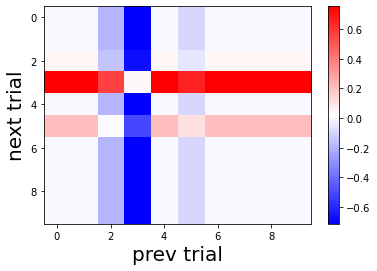

In [510]:
i = 13
fig,ax=plt.subplots()
im=ax.imshow(diff[:,i,:,i],aspect='auto',cmap='bwr')
# ax.invert_yaxis()
plt.colorbar(im)
plt.ylabel('next trial')
plt.xlabel('prev trial')

In [466]:
xx_normed.rolling(2,axis=1).apply(lambda aa:np.subtract.outer(aa[:,0],aa[:,1]),raw=True)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [462]:
np.subtract.outer(xx_normed[0],xx_normed).shape

/tmp/ipykernel_3776705/2213060631.py:1: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  np.subtract.outer(xx_normed[0],xx_normed).shape
/tmp/ipykernel_3776705/2213060631.py:1: FutureWarning: outer method for ufunc <ufunc 'subtract'> is not implemented on pandas objects. Returning an ndarray, but in the future this will raise a 'NotImplementedError'. Consider explicitly converting the DataFrame to an array with '.to_numpy()' first.
  np.subtract.outer(xx_normed[0],xx_normed).shape


(10, 10, 21)